# a04 Example - Bayesian Optimization Interface

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt

from pyscan_optimization.bayesian_optimization import bayes_opt_main

## Setup devices

In [2]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define a measure function

In [3]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

# Define live plot

In [4]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

# Define runinfo

In [5]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

# Implement `BayesianOptimizeScan`

In [6]:
class BayesianOptimizeScan(ps.AbstractOptimizeScan):
    """
    Maximizes objective function
    """

    def __init__(self, initialization_dict, prop, optimizer_inputs, sample_function_output,
                 domain_info_list,
                 dt=0., iteration_max=100, extremum='min',
                 ei_threshold=1e-1):
        super().__init__(initialization_dict, prop, optimizer_inputs, sample_function_output,
                         iteration_max=iteration_max, dt=dt)
        self.domain = domain_info_list
        self.X_train = np.empty((1, len(initialization_dict)))
        self.X_train[0] = np.array(list(initialization_dict.values()))
        self.y_train = None # TODO: multidim output? np.empty((1, 1))
        self.extremum = extremum
        self.ei_threshold = ei_threshold
    
    def step_optimizer(self, index, experiment):

        def postproc_extremum(y, extremum):
            match extremum:
                case 'max':
                    return y
                case 'min':
                    return -y

        if index == 1: # first optim step after init
            self.y_train = np.empty(1)
            self.y_train[0] = postproc_extremum(experiment.__dict__[self.sample_f_out][0], self.extremum)
        else:
            i_prev = index - 1
            self.X_train = np.append(self.X_train, [[experiment.__dict__[measurement][i_prev] for measurement in self.opt_in]], axis=0)
            self.y_train = np.append(self.y_train, [postproc_extremum(experiment.__dict__[self.sample_f_out][i_prev], self.extremum)], axis=0)
            if index > 0 and index < 6:
                f_in_next = [[2., 1.], [6., 3.], [4., 6.], [9., 9.], [8., 1.], [1., 9.]][index]
                # f_in_next = [[2., 1.], [6., 3.]][index]
                return f_in_next
            else:
                f_in_next = bayes_opt_main(self.domain, self.X_train, self.y_train, ei_threshold=self.ei_threshold)
                if f_in_next is not None:
                    # TODO: must be float64 as per instrument_driver.py?
                    # TODO: for gpu: .cpu().detach().numpy()
                    return f_in_next.numpy().astype(np.float64)
                else:
                    self.running = False
                    return None # TODO: last return can be none? need to trim this?

# Instantiate OptimizeScan

In [7]:
runinfo.scan0 = BayesianOptimizeScan({'v1': 2., 'v2': 1.}, 'voltage', ('v1_readout', 'v2_readout'), 'vf',
                                     [(0, 10, .1), (0, 10, .1)], 
                                     iteration_max=100, dt=1., extremum='min')

# Run Experiments

In [8]:
expt = ps.Experiment(runinfo, devices, time=True)
expt.start_thread()

X_init: [[2. 1.]
 [2. 1.]
 [4. 6.]
 [9. 9.]
 [8. 1.]
 [1. 9.]]
y_init: [-29. -29.  -0. -34. -41. -18.]
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
mean unique: (array([-4.09999919e+01, -4.08320745e+01, -4.08320743e+01, ...,
       -2.46900839e-01, -2.46900839e-01, -1.19069119e-05], shape=(9887,)), array([1, 1, 1, ..., 1, 1, 1], shape=(9887,)))
stdev unique: (array([1.22494297e-02, 1.41444220e-02, 1.41444220e-02, ...,
       1.43182801e+01, 1.43182801e+01, 1.43182801e+01], shape=(7797,)), array([1, 3, 1, ..., 5, 2, 1], shape=(7797,)))
expected_improvemnt unique: (array([0.00000000e+00, 1.56853845e-88, 1.56891631e-88, ...,
       1.53198041e+00, 1.53198041e+00, 1.53198107e+00], shape=(9882,)), array([4, 1, 1, ..., 1, 1, 1], shape=(9882,)))
max_expected_improvement: 1.5319810709710104
next_index_improve: 3763
next_domain_values: tensor([3.7000, 6.3000])
X_init: [[2.         1.        ]
 [2.         1.        ]
 [4.         6.        ]
 [9.         9.        ]
 [8.         1.

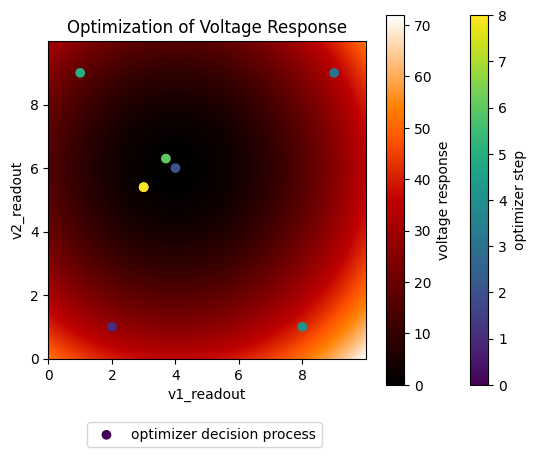

In [9]:
fig, ax = plt.subplots()
cb0 = cb1 = None
try:
    plot_optim_live(expt)
except KeyboardInterrupt:
    expt.stop()

In [10]:
runinfo.scan0.X_train

array([[2.        , 1.        ],
       [2.        , 1.        ],
       [4.        , 6.        ],
       [9.        , 9.        ],
       [8.        , 1.        ],
       [1.        , 9.        ],
       [3.70000005, 6.29999971],
       [3.        , 5.4000001 ]])

In [11]:
runinfo.scan0.y_train

array([-29.        , -29.        ,  -0.        , -34.        ,
       -41.        , -18.        ,  -0.1799998 ,  -1.35999989])

In [12]:
expt.__dict__

{'runinfo': <pyscan.measurement.run_info.RunInfo at 0x1762ef7a120>,
 'devices': <pyscan.general.item_attribute.ItemAttribute at 0x17628af4d70>,
 'expt_thread': <Thread(Thread-3 (run), stopped daemon 21292)>,
 'v1_voltage': [2.0,
  4.0,
  9.0,
  8.0,
  1.0,
  np.float64(3.700000047683716),
  np.float64(3.0)],
 'v2_voltage': [1.0,
  6.0,
  9.0,
  1.0,
  9.0,
  np.float64(6.299999713897705),
  np.float64(5.400000095367432)],
 'v1_readout': array([2.        , 2.        , 4.        , 9.        , 8.        ,
        1.        , 3.70000005, 3.        , 3.        ]),
 'v2_readout': array([1.        , 1.        , 6.        , 9.        , 1.        ,
        9.        , 6.29999971, 5.4000001 , 5.4000001 ]),
 'vf': array([29.        , 29.        ,  0.        , 34.        , 41.        ,
        18.        ,  0.1799998 ,  1.35999989,  1.35999989])}

In [13]:
expt['v1_readout'][0]

np.float64(2.0)

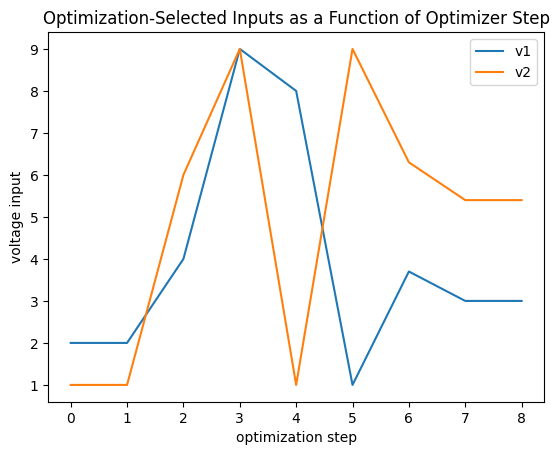

In [14]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

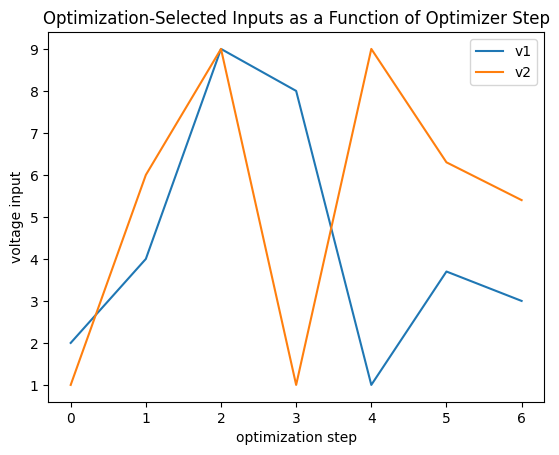

In [15]:
plt.plot(list(zip(expt.v1_voltage, expt.v2_voltage))) # TODO: trim unused inputs from scan dict?
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

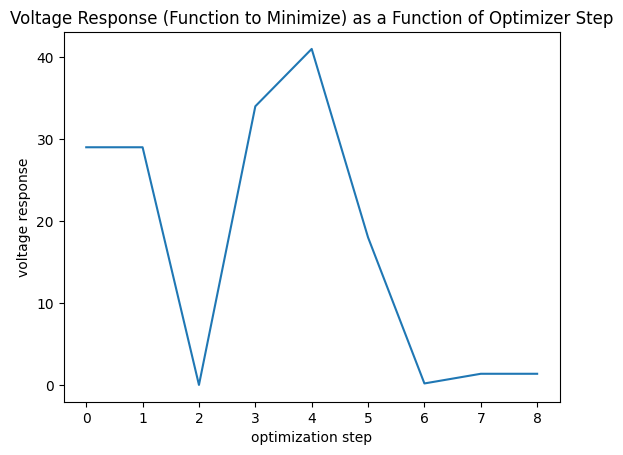

In [16]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

In [17]:
def plot_optim_pcm():
    fig, ax = plt.subplots()
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                         cmap='viridis')
    ax.set_box_aspect(1)
    fig.colorbar(scatter, label="optimizer step")
    fig.colorbar(pcm, label="voltage response")
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

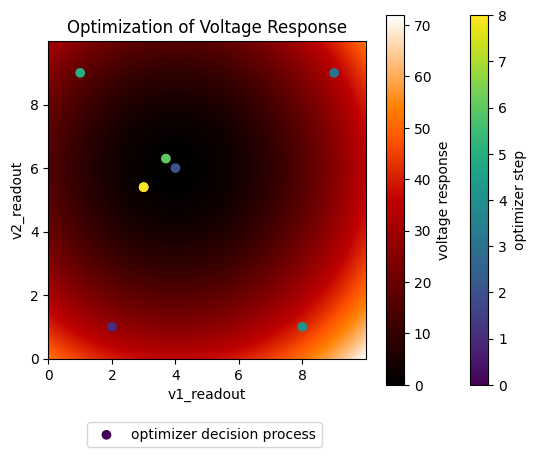

In [18]:
plot_optim_pcm()

In [19]:
def plot_optim_3d(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, expt.vf, c=range(len(expt.v1_readout)))
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step", pad=.1)
    ax.legend(["voltage response function", "optimizer decision process",], loc='lower left', bbox_to_anchor=(.2, -.2))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimization of Voltage Response")

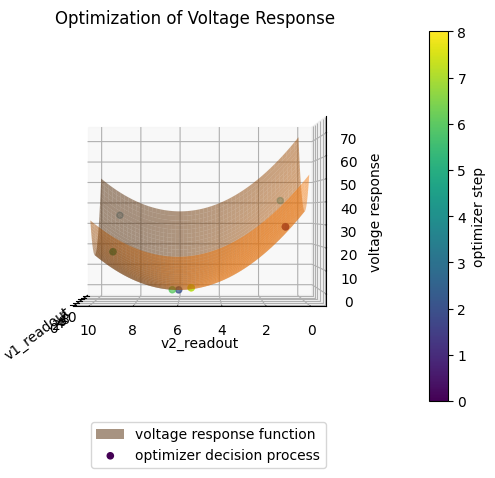

In [20]:
plot_optim_3d(0, 180)

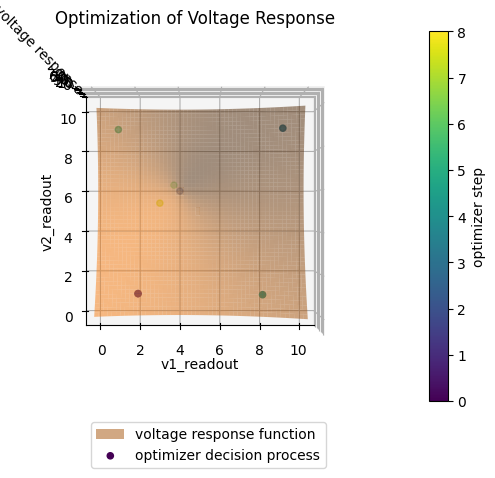

In [21]:
plot_optim_3d(90, 270)

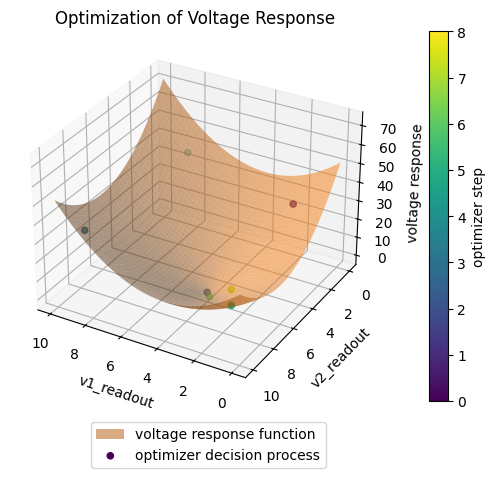

In [22]:
plot_optim_3d(30, 120)